In [1]:
import torch
from gensim.models import Word2Vec
import torch.nn as nn
import cv2
from matplotlib.pyplot import imshow
import numpy as np

In [2]:
w2v = Word2Vec.load("bare_minimum")
w2v.wv["bear"].shape

(16,)

In [3]:
w2v.wv.__len__()

10

In [4]:
bear = cv2.imread("bear.jpg")
bear = cv2.resize(bear,(128,128))
hospital = cv2.imread("hos.png")
hospital = cv2.resize(hospital,(128,128))
strike = cv2.imread("strike.jpg")
strike = cv2.resize(strike,(128,128))
imgs = np.array([(i.reshape(1,3,128,128) / 256).astype(np.float32) for i in [bear, hospital, strike]])

In [5]:
class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.dense1 = nn.Linear(16, 256)
        
        self.upsample1 = nn.ConvTranspose2d(1, 1, 3, 2, 1, 1)
        self.upsample2 = nn.ConvTranspose2d(1, 1, 3, 2, 1, 1)
        self.upsample3 = nn.ConvTranspose2d(1, 1, 3, 2, 1, 1)
        
        self.mesh = nn.Conv2d(4, 3, 3, padding=1)
        
    def forward(self, word_vec, simage):
        
        x = self.dense1(word_vec)
        x = nn.functional.relu(x)
        
        x = x.reshape((-1,1,16,16))
        
        x = self.upsample1(x)
        x = nn.functional.relu(x)
        x = self.upsample2(x)
        x = nn.functional.relu(x)
        x = self.upsample3(x)
        x = nn.functional.relu(x)
        
        x = torch.concat((simage, x), dim=1)
        return self.mesh(x)
    
class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Conv2d(3, 3, 3, padding=1)
        self.conv2 = nn.Conv2d(3, 3, 3, padding=1)
        self.conv3 = nn.Conv2d(3, 3, 3, padding=1)
        
        self.pool1 = nn.MaxPool2d(2)
        self.conv4 = nn.Conv2d(3, 3, 3, padding=1)
        self.pool2 = nn.MaxPool2d(2)
        self.conv5 = nn.Conv2d(3,6,3,padding=1)
        self.pool3 = nn.MaxPool2d(2)
        self.conv6 = nn.Conv2d(6,1,3,padding=1)
        
        self.flatten = nn.Flatten()
        self.classify1 = nn.Linear(266,128)
        self.classify2 = nn.Linear(128,64)
        self.classify3 = nn.Linear(64, 10)
        
        self.next1 = nn.Conv2d(3,16,3,padding=1)
        self.next2 = nn.Conv2d(16,16,3,padding=1)
        self.next3 = nn.Conv2d(16, 3, 1)
        
        
    def forward(self, input, context):
        
        x = self.conv1(input)
        x = nn.functional.relu(x)
        x = self.conv2(x)
        x = nn.functional.relu(x)
        x = self.conv3(x)
        x = nn.functional.relu(x)
        
        c = self.pool1(x)
        c = self.conv4(c)
        c = nn.functional.relu(c)
        c = self.pool2(c)
        c = self.conv5(c)
        c = nn.functional.relu(c)
        c = self.pool3(c)
        c = self.conv6(c)
        c = nn.functional.relu(c)

        c = self.flatten(c)
        c = torch.concat((c, context), dim=1)
        c = self.classify1(c)
        c = nn.functional.relu(c)
        c = self.classify2(c)
        c = nn.functional.relu(c)
        c = self.classify3(c)
        
        n = self.next1(x)
        n = self.next2(n)
        n = self.next3(n)
        
        return c, n

In [6]:
enc = Encoder()
dec = Decoder()

In [7]:
a = enc(torch.from_numpy(w2v.wv['bear']), torch.zeros(1,3,128,128))
dec(a, torch.zeros(1,10))

C:\Users\Alexander\AppData\Local\Temp\ipykernel_3160\1061091042.py:1: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\utils\tensor_numpy.cpp:209.)
  a = enc(torch.from_numpy(w2v.wv['bear']), torch.zeros(1,3,128,128))


(tensor([[-0.0985,  0.0613, -0.0938,  0.0441, -0.0980, -0.0391,  0.0398, -0.1168,
           0.0892, -0.0099]], grad_fn=<AddmmBackward0>),
 tensor([[[[ 0.1490,  0.1586,  0.1586,  ...,  0.1586,  0.1586,  0.1046],
           [ 0.1865,  0.1987,  0.1987,  ...,  0.1987,  0.1987,  0.1393],
           [ 0.1865,  0.1987,  0.1987,  ...,  0.1987,  0.1987,  0.1393],
           ...,
           [ 0.1865,  0.1987,  0.1987,  ...,  0.1987,  0.1987,  0.1393],
           [ 0.1865,  0.1987,  0.1987,  ...,  0.1987,  0.1987,  0.1393],
           [ 0.1612,  0.1861,  0.1861,  ...,  0.1861,  0.1861,  0.1620]],
 
          [[-0.0384, -0.0209, -0.0209,  ..., -0.0209, -0.0209, -0.0492],
           [-0.0534, -0.0355, -0.0355,  ..., -0.0355, -0.0355, -0.0579],
           [-0.0534, -0.0355, -0.0355,  ..., -0.0355, -0.0355, -0.0579],
           ...,
           [-0.0534, -0.0355, -0.0355,  ..., -0.0355, -0.0355, -0.0579],
           [-0.0534, -0.0355, -0.0355,  ..., -0.0355, -0.0355, -0.0579],
           [-0.0757, -0

In [8]:
sentences = [["the", "bear", "is", "eating", "honey"],
             ["where", "is", "the", "hospital"],
             ["students", "are", "striking"]]
images = torch.tensor(imgs)

In [9]:
# define optim
crit_words = nn.CrossEntropyLoss()
crit_image = nn.MSELoss()

s = nn.ModuleList([enc,dec])

optim = torch.optim.Adam(s.parameters())

In [10]:
## Training loop
epochs = 50
torch.manual_seed(42)
for epoch in range(epochs):
    sents = []
    for img,sent in zip(images,sentences):
        optim.zero_grad()
        canvas = torch.zeros(1,3,128,128)
        for w in sent:
            canvas = enc(torch.from_numpy(w2v.wv[w]).float(), canvas)
        loss = crit_image(img, canvas)
        pic = canvas.clone()
        context = torch.zeros(1,10)
        outs = []
        for w in sent:
            word, canvas = dec(canvas, context)
            context = word
            loss = loss + crit_words(word, torch.tensor([w2v.wv.key_to_index[w]]))
            outs.append(word)
        loss.backward()
        optim.step()
        sents.append(outs)

In [11]:
[[w2v.wv.index_to_key[w.argmax()] for w in sen] for sen in sents]

[['the', 'is', 'is', 'striking', 'striking'],
 ['the', 'is', 'is', 'striking'],
 ['the', 'is', 'is']]

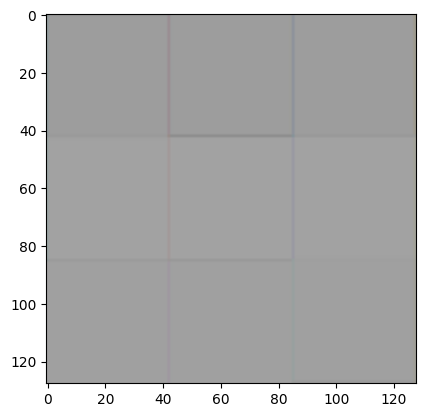

In [12]:
imshow(nn.functional.sigmoid(pic).detach().numpy().reshape(128,128,3))